## Article Recommender with Text Embedding, Classification, and Extraction

This is a simple demonstration of how we can stack multiple NLP models together 
to get an output much closer to our desired outcome.

Embeddings can capture the meaning of a piece of text beyond keyword-matching. In this article, we will build a simple news article recommender system that computes the embeddings of all available articles and recommend the most relevant articles based on embeddings similarity. 

We will also make the recommendation tighter by using text classification to recommend only articles within the same category. We will then extract a list of tags from each recommended article, which can further help readers discover new articles. 

All this will be done via three Cohere API endpoints stacked together: Embed, Classify, and Generate.

![Article recommender with Embed, Classify, and Generate](https://github.com/cohere-ai/notebooks/raw/main/notebooks/images/article-recommender/article-rec-1.png)



We will implement the following steps:

**1: Find the most similar articles to the one currently reading using embeddings.**

**2: Keep only articles of the same category using text classification.**

**3: Extract tags from these articles.**

**4: Show the top 5 recommended articles.**

In [ ]:
! pip install cohere

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 18.0 MB 166 kB/s 


In [ ]:
import numpy as np
import pandas as pd
import re
import cohere
api_key = '{apikey}' # Paste your API key here. Remember to not share it publicly 
co = cohere.Client(api_key)

# **1: Find the most similar articles to the one currently reading using embeddings**

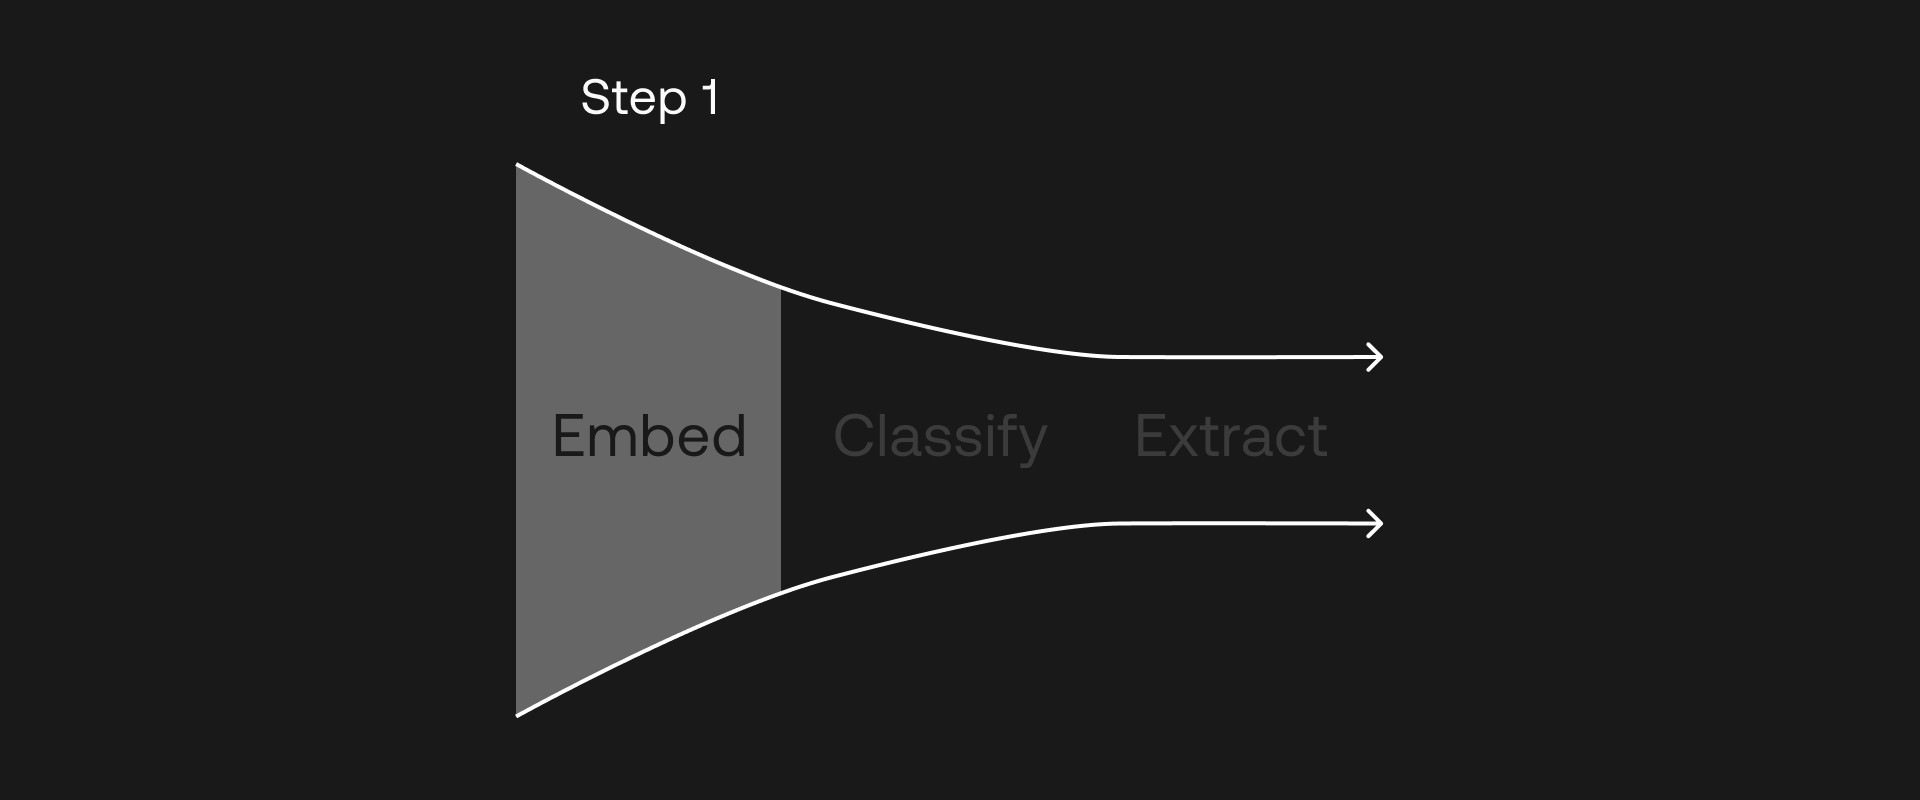

## 1.1: Get articles

Throughout this article, we'll use the [BBC news article dataset](https://www.kaggle.com/competitions/learn-ai-bbc/data?select=BBC+News+Train.csv) as an example [[Source]](http://mlg.ucd.ie/datasets/bbc.html). This dataset consists of articles from a few categories: business, politics, tech, entertainment, and sport.

We'll extract a subset of the data and in Step 1, use the first 100 data points.



In [ ]:
# Load the dataset to a dataframe
df = pd.read_csv('https://raw.githubusercontent.com/cohere-ai/notebooks/main/notebooks/data/bbc_news_subset.csv', delimiter=',')

# Select a portion of the dataset 
INP_START = 0
INP_END = 100
df_inputs = df.iloc[INP_START:INP_END]
df_inputs = df_inputs.copy()

# Remove columns we don't need
df_inputs.drop(['ArticleId','Category'],axis=1,inplace=True)

# View the data
df_inputs.head()

,Text
0,worldcom ex-boss launches defence lawyers defe...
1,german business confidence slides german busin...
2,bbc poll indicates economic gloom citizens in ...
3,lifestyle governs mobile choice faster bett...
4,enron bosses in $168m payout eighteen former e...


## 1.2: Turn articles into embeddings


Next we turn each article text into embeddings. An [embedding](https://docs.cohere.ai/embedding-wiki) is a list of numbers that our models use to represent a piece of text, capturing its context and meaning.

We do this by calling Cohere's [Embed endpoint](https://docs.cohere.ai/embed-reference), which takes in text as input and returns embeddings as output.

In [ ]:
# Get text embeddings via the Embed endpoint
embeds = []
for article in df_inputs['Text']:
  output = co.embed(
              model='large',
              texts=[article])
  embeds += output.embeddings
  
print('Number of articles:', len(embeds))

Number of articles: 100


## 1.3: Pick one article and find the most similar articles

Next, we pick any one article to be the one the reader is currently reading (let's call this the target) and find other articles with the most similar embeddings (let's call these candidates) using cosine similarity.

[Cosine similarity](https://en.wikipedia.org/wiki/Cosine_similarity) is a metric that measures how similar sequences of numbers are (embeddings in our case), and we compute it for each target-candidate pair. 

In [ ]:
# Choose one article ID as the one you are currently reading
print(f'Choose one article ID between {INP_START} and {INP_END-1} below...')

Choose one article ID between 0 and 99 below...


In [ ]:
# Enter your article ID
READING_IDX = 70

# Get embedding for the article
reading = embeds[READING_IDX]

In [ ]:
# Calculate cosine similarity between the target and candidate articles

from sklearn.metrics.pairwise import cosine_similarity

def get_similarity(target,candidates):
  # Turn list into array
  candidates = np.array(candidates)
  target = np.expand_dims(np.array(target),axis=0)

  # Calculate cosine similarity
  similarity_scores = cosine_similarity(target,candidates)
  similarity_scores = np.squeeze(similarity_scores).tolist()

  # Sort by descending order in similarity
  similarity_scores = list(enumerate(similarity_scores))
  similarity_scores = sorted(similarity_scores, key=lambda x:x[1], reverse=True)

  # Return similarity scores
  return similarity_scores

In [ ]:
# Get the similarity between the target and candidate articles
similarity = get_similarity(reading,embeds)

# View the top 5 articles
print('Target:')
print(f'[ID {READING_IDX}]',df_inputs['Text'][READING_IDX][:100],'...','\n')

print('Candidates:')
for i in similarity[1:6]: # Exclude the target article
  print(f'[ID {i[0]}]',df_inputs['Text'][i[0]][:100],'...')

Target:
[ID 70] aragones angered by racism fine spain coach luis aragones is furious after being fined by the spanis ... 

Candidates:
[ID 23] ferguson urges henry punishment sir alex ferguson has called on the football association to punish a ...
[ID 59] benitez delight after crucial win liverpool manager rafael benitez admitted victory against deportiv ...
[ID 51] mourinho defiant on chelsea form chelsea boss jose mourinho has insisted that sir alex ferguson and  ...
[ID 86] boris opposes mayor apology ken livingstone should  stick to his guns  and not apologise for his  na ...
[ID 15] wenger signs new deal arsenal manager arsene wenger has signed a new contract to stay at the club un ...


# **2: Keep only articles of the same category using text classification**

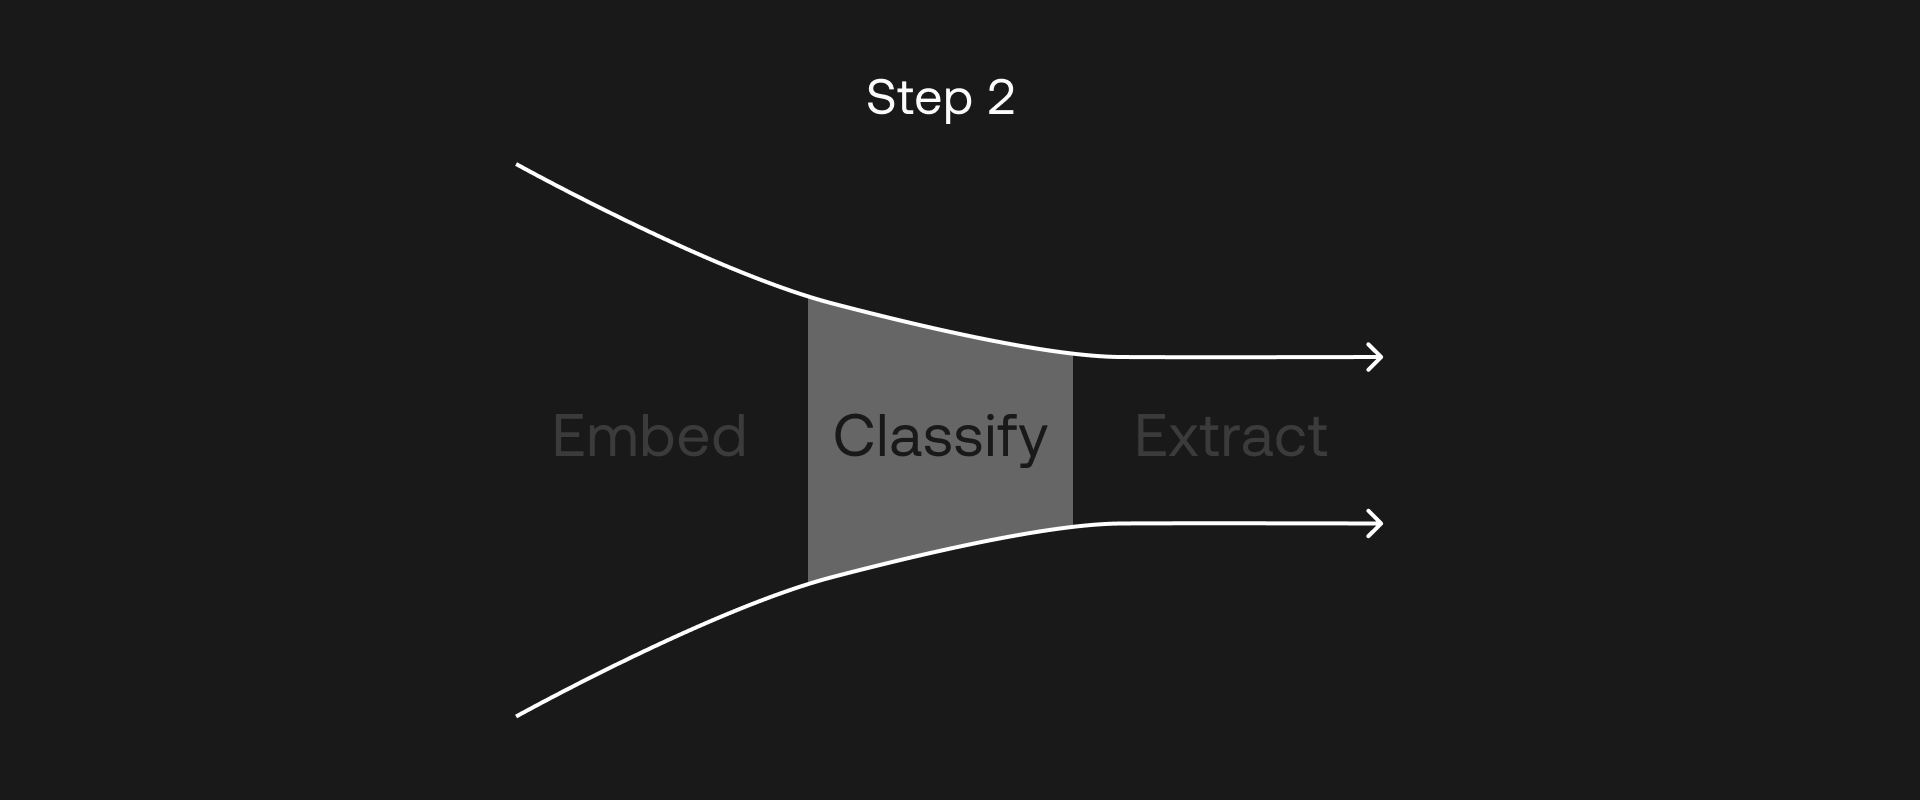

In the example above (Article ID 70 as the target), we see that the top 5 most similar articles given by the system are very relevant. The target is a football/soccer article, and the system duly recommended very similar articles despite this dataset also containing articles from other sports like tennis and rugby.
 
However, not all of them are. The fourth recommended article (ID 86) is not a sports article, but rather politics. Reading the text, it's likely because the target is news about a clash of individuals (i.e. anger about a racism fine), which happens to be what that politics article is also about (i.e. disagreement over an apology). So these two articles' meanings are similar in this way, captured in the embeddings.
 
Perhaps we can make the system better by only recommending articles of the same category. For this, let's build a news category classifier.

## 2.1: Build a classifier


We use Cohere's [Classify endpoint](https://docs.cohere.ai/classify-reference) to build a news category classifier, classifying articles into five categories: Business, Politics, Tech, Entertainment, and Sport. 

A typical text classification model requires hundreds/thousands of data points to train, but with this endpoint, we can build a classifier with a few as five examples per class.

To build the classifier, we need a set of examples consisting of text (news text) and labels (news category). The BBC News dataset happens to have both (columns 'Text' and 'Category'), so this time we’ll use the categories for building our examples. For this, we will set aside another portion of dataset.

In [ ]:
# Select a portion of the dataset to sample the classification examples from
EX_START = 100
EX_END = 200
df_examples = df.iloc[EX_START:EX_END]
df_examples = df_examples.copy()

# Remove columns we don't need
df_examples.drop(['ArticleId'],axis=1,inplace=True)

# View the data
df_examples.head()

,Text,Category
100,honda wins china copyright ruling japan s hond...,business
101,ukip could sue veritas defectors the uk indepe...,politics
102,security warning over fbi virus the us feder...,tech
103,europe backs digital tv lifestyle how people r...,tech
104,celebrities get to stay in jungle all four con...,entertainment


With the Classify endpoint, there is a limit of 2048 tokens with the medium model. This means full articles won't be able to fit in the examples, so we will approximate and limit each article to its first 300 characters.

In [ ]:
# Shorten the example articles (because the medium endpoint max token limit is 2048)
MAX_CHARS = 300

def shorten_text(text):
  return text[:MAX_CHARS]

df_examples['Text'] = df_examples['Text'].apply(shorten_text)

The Classify endpoint needs a minimum of 5 examples for each category, which we will sample randomly from the dataset. We have 5 categories, so we will have a total of 25 examples.

In [ ]:
# Set the number of examples per category
EX_PER_CAT = 5 

# Get the list of all available categories
categories = df_examples['Category'].unique().tolist()

# Create list of examples containing texts and labels
ex_texts = []
ex_labels = []
for category in categories:
  df_category = df_examples[df_examples['Category'] == category]
  samples = df_category.sample(n=EX_PER_CAT, random_state=42)
  ex_texts += samples['Text'].tolist()
  ex_labels += samples['Category'].tolist()

print(f'Number of examples per category: {EX_PER_CAT}')
print(f'List of categories: {categories}')
print(f'Number of categories: {len(categories)}')
print(f'Total number of examples: {len(ex_texts)}')

Number of examples per category: 5
List of categories: ['business', 'politics', 'tech', 'entertainment', 'sport']
Number of categories: 5
Total number of examples: 25


Once the examples are ready, we can now get the classifications. Here is a function that returns the classification given an input.

In [ ]:
# Get classifications via the Classify endpoint

from cohere.classify import Example

# Collate the examples
examples = []
for txt, lbl in zip(ex_texts,ex_labels):
  examples.append(Example(txt,lbl))

# Perform classification
def classify_text(text,examples):
  classifications = co.classify(
    model='medium',
    taskDescription='',
    outputIndicator='',
    inputs=[text],
    examples=examples
    )
  return classifications.classifications[0].prediction

## 2.2: Measure its performance

Before actually using the classifier, let's first test its performance. Here we take another 100 data points as the test dataset and the classifier will predict its class i.e. news category.

In [ ]:
# Select a portion of the dataset for testing the classifier
TEST_START = 200
TEST_END = 300
df_test = df.iloc[TEST_START:TEST_END]
df_test = df_test.copy()

# Remove columns we don't need
df_test.drop(['ArticleId'],axis=1,inplace=True)

# Shorten the text to fit token limit
df_test['Text'] = df_test['Text'].apply(shorten_text)

# View the data
df_test.head()

,Text,Category
200,sa return to mauritius top seeds south africa ...,sport
201,snow patrol feted at irish awards snow patrol ...,entertainment
202,clyde 0-5 celtic celtic brushed aside clyde to...,sport
203,bad weather hits nestle sales a combination of...,business
204,net fingerprints combat attacks eighty large n...,tech


In [ ]:
# Run classifier predictions on the test dataset (this will take a few minutes)

# Predicted classes
# predictions = []
# for article in df_test['Text']:
#   predictions.append(classify_text(article,examples))

predictions = df_test['Text'].apply(classify_text, args=(examples,)).tolist()

# Actual classes
actual = df_test['Category'].tolist()

In [ ]:
# Compute metrics on the test dataset
from sklearn.metrics import accuracy_score

accuracy = accuracy_score(actual, predictions)
print(f'Accuracy: {accuracy*100}')

Accuracy: 91.0


We get a good accuracy score of 91%, so the classifier is ready to be 
implemented in our recommender system.

# **3: Extract tags from these articles.**

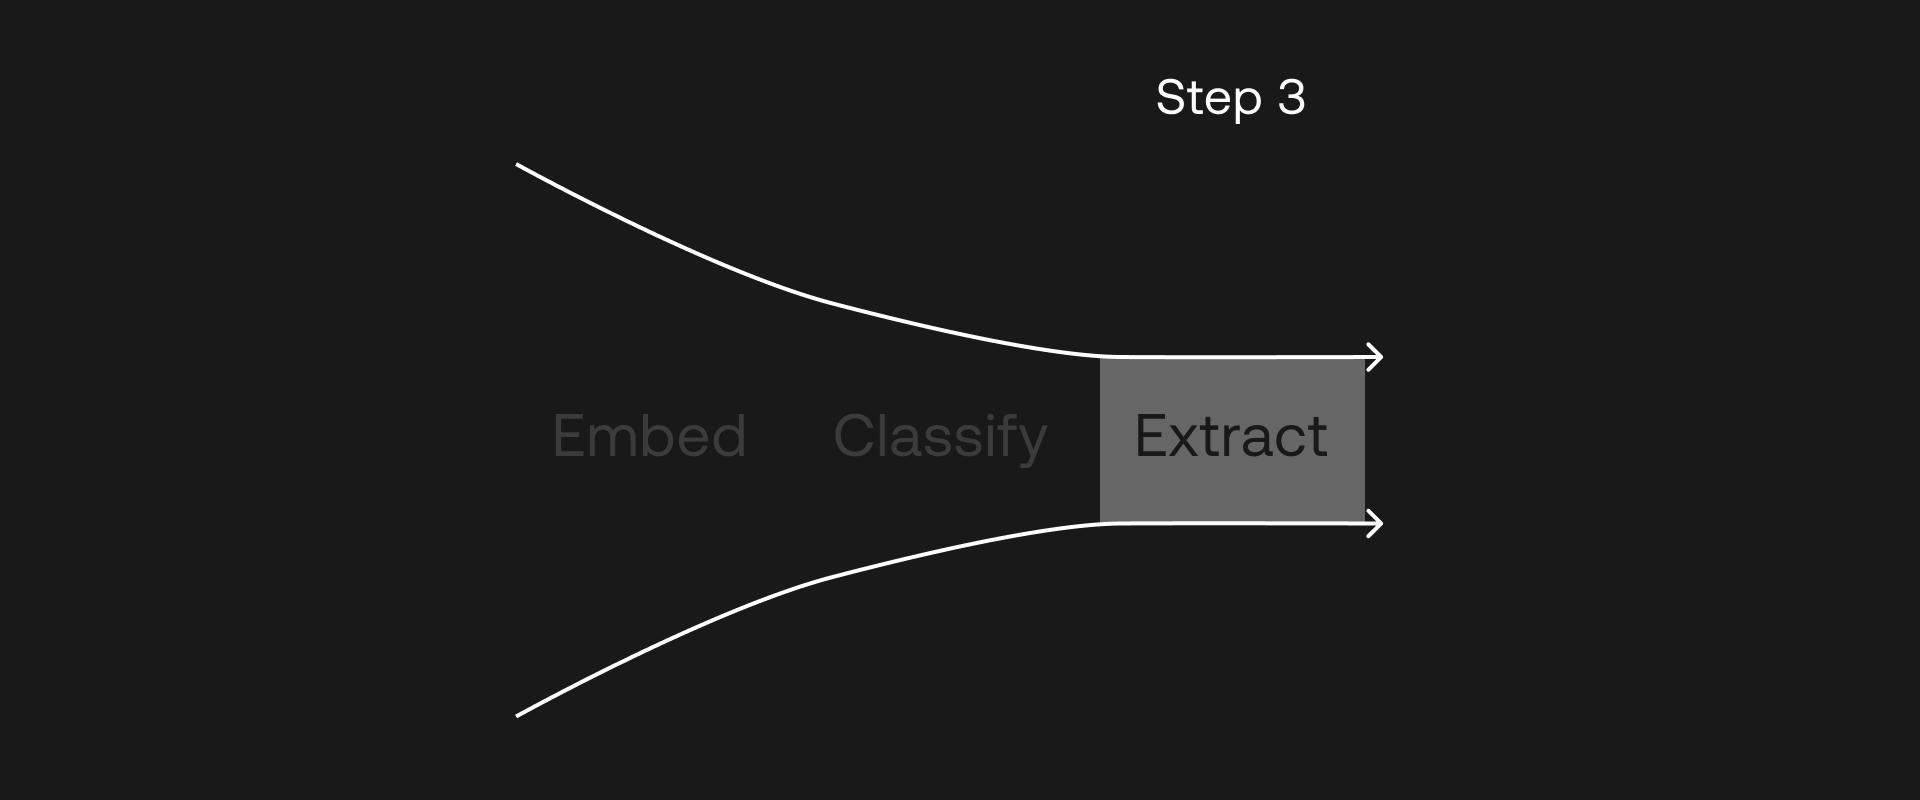

We now proceed to the tags extraction step. Compared to the previous two steps, this step is not about sorting or filtering articles, but rather enriching them with more information. 

We do this by [prompting](https://docs.cohere.ai/prompt-engineering-wiki) Cohere's [Generate endpoint](https://docs.cohere.ai/generate-reference) with a few examples of text and its tags. We then feed the articles from the classifier step and the endpoint will generate the corresponding tags.

There are more than one way to construct the prompt, depending on what you'd lile to extract. In my case, the tags I'd like to extract are primarily the names of a person, company, or organization, and perhaps also some generic keywords. That was the idea behind the example tags I put in the prompt, which you can see on the Cohere Playground screenshot below...

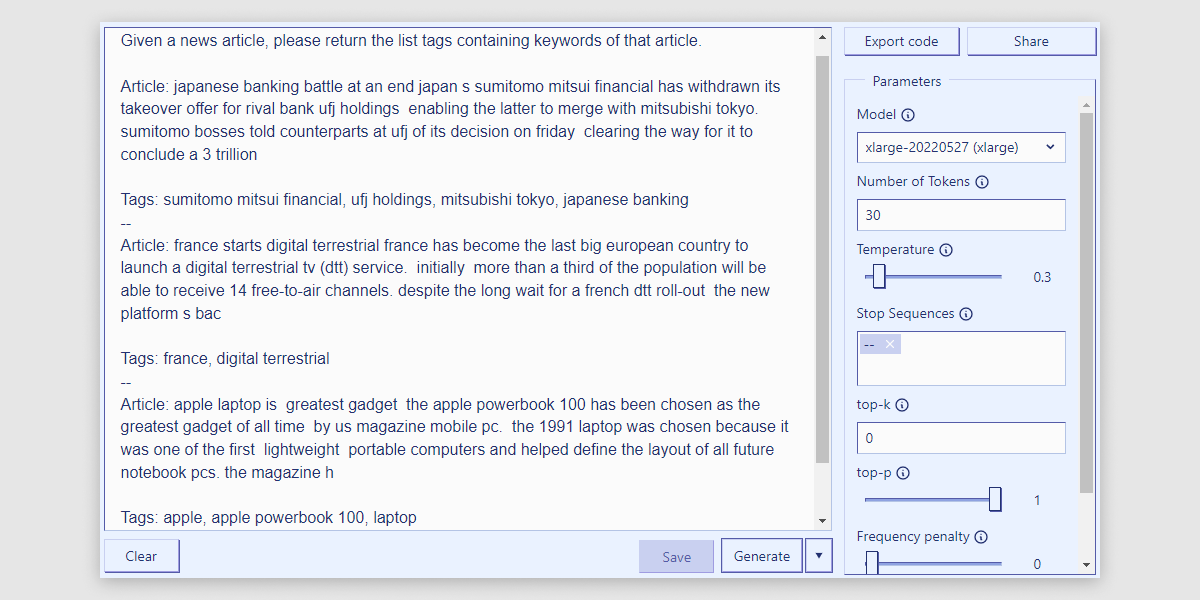

In [ ]:
# Create the base prompt containing extraction examples
# base_prompt = 'Given a news article, please return the list tags containing proper nouns.\n\nArticle: japanese banking battle at an end japan s sumitomo mitsui financial has withdrawn its takeover offer for rival bank ufj holdings  enabling the latter to merge with mitsubishi tokyo.  sumitomo bosses told counterparts at ufj of its decision on friday  clearing the way for it to conclude a 3 trillion\n\nTags: sumitomo mitsui financial, ufj holdings, mitsubishi tokyo\n--\nArticle: france starts digital terrestrial france has become the last big european country to launch a digital terrestrial tv (dtt) service.  initially  more than a third of the population will be able to receive 14 free-to-air channels. despite the long wait for a french dtt roll-out  the new platform s bac\n\nTags: france\n--\nArticle: apple laptop is  greatest gadget  the apple powerbook 100 has been chosen as the greatest gadget of all time  by us magazine mobile pc.  the 1991 laptop was chosen because it was one of the first  lightweight  portable computers and helped define the layout of all future notebook pcs. the magazine h\n\nTags: apple, apple powerbook 100, mobile pc\n--\nArticle:'

base_prompt = 'Given a news article, please return the list tags containing keywords of that article.\n\nArticle: japanese banking battle at an end japan s sumitomo mitsui financial has withdrawn its takeover offer for rival bank ufj holdings  enabling the latter to merge with mitsubishi tokyo.  sumitomo bosses told counterparts at ufj of its decision on friday  clearing the way for it to conclude a 3 trillion\n\nTags: sumitomo mitsui financial, ufj holdings, mitsubishi tokyo, japanese banking\n--\nArticle: france starts digital terrestrial france has become the last big european country to launch a digital terrestrial tv (dtt) service.  initially  more than a third of the population will be able to receive 14 free-to-air channels. despite the long wait for a french dtt roll-out  the new platform s bac\n\nTags: france, digital terrestrial\n--\nArticle: apple laptop is  greatest gadget  the apple powerbook 100 has been chosen as the greatest gadget of all time  by us magazine mobile pc.  the 1991 laptop was chosen because it was one of the first  lightweight  portable computers and helped define the layout of all future notebook pcs. the magazine h\n\nTags: apple, apple powerbook 100, laptop\n--\nArticle:'

We call the endpoint by specifying a few settings, and it will generate the corresponding extractions.

In [ ]:
# Get extractions via the Generate endpoint
def extract_tags(complete_prompt):
  prediction = co.generate(
    model='xlarge',
    prompt=complete_prompt,
    max_tokens=30,
    temperature=0.3,
    k=0,
    p=1,
    frequency_penalty=0,
    presence_penalty=0,
    stop_sequences=["--"],
    return_likelihoods='NONE')
  return prediction.generations[0].text

# **4: Show the top 5 recommended articles.**

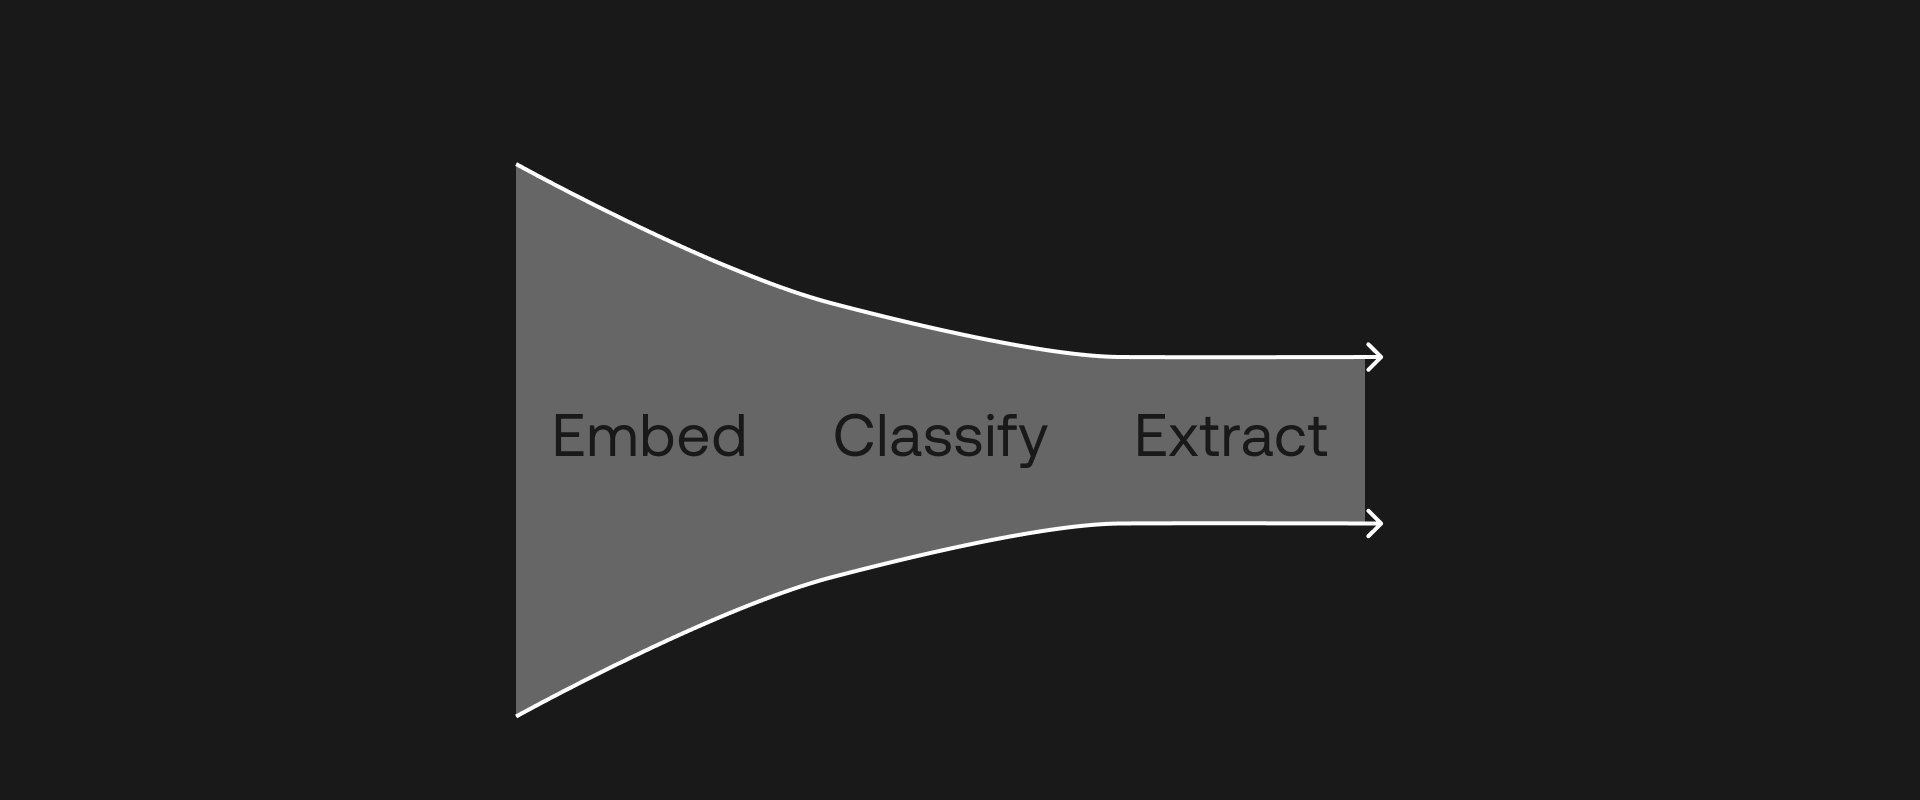

*Note: The outputs may vary. This notebook uses the following model versions: Embed (large-20220425), Classify (medium-20220425), and Generate (xlarge-20220427)*

Let's now put everything together for our article recommender system.

First, we select the target article and compute the similarity scores against the candidate articles.

In [ ]:
# Choose one article ID as the one you are currently reading
print(f'Choose one article ID between {INP_START} and {INP_END-1} below...')

Choose one article ID between 0 and 99 below...


In [ ]:
# Enter your article ID
READING_IDX = 70

# Get embedding for the article
reading = embeds[READING_IDX]

# Get the similarity between the target and candidate articles
similarity = get_similarity(reading,embeds)

Next, we filter the articles via classification. Finally, we extract the keywords from each article and show the recommendations.


In [ ]:
# Choose the number of articles to recommend
SHOW_TOP = 5

# Shorten the text to fit token limit
df_inputs = df_inputs.copy()
df_inputs['Text'] = df_inputs['Text'].apply(shorten_text)

# Get the recommendations
def get_recommendations(reading_idx,similarity,show_top):

  # Show the current article
  print('------  You are reading...  ------')
  print(f'[ID {READING_IDX}] Article:',df_inputs['Text'][reading_idx][:MAX_CHARS]+'...\n')

  # Show the recommended articles
  print('------  You might also like...  ------')

  # Classify the target article
  target_class = classify_text(df_inputs['Text'][reading_idx],examples) 

  count = 0
  for idx,score in similarity:

    # Classify each candidate article
    candidate_class = classify_text(df_inputs['Text'][idx],examples)

    # Show recommendations
    if target_class == candidate_class and idx != reading_idx:
      selection = df_inputs['Text'][idx][:MAX_CHARS]
      print(f'[ID {idx}] Article:',selection+'...')

      # Extract and show tags
      tags_raw = extract_tags(base_prompt+selection)
      tags_clean = re.findall("(?s)Tags: (.+?)\\n",tags_raw)
      if tags_clean:
          print(f'Tags: {str(tags_clean[0])}\n')
      else:
          print(f'Tags: none\n')      

      # Increment the article count
      count += 1

      # Stop once articles reach the SHOW_TOP number
      if count == show_top:
        break

In [ ]:
# Show the recommended articles
get_recommendations(READING_IDX,similarity,SHOW_TOP)

------  You are reading...  ------
[ID 70] Article: aragones angered by racism fine spain coach luis aragones is furious after being fined by the spanish football federation for his comments about thierry henry.  the 66-year-old criticised his 3000 euros (£2 060) punishment even though it was far below the maximum penalty.  i am not guilty  nor do i ...

------  You might also like...  ------
[ID 23] Article: ferguson urges henry punishment sir alex ferguson has called on the football association to punish arsenal s thierry henry for an incident involving gabriel heinze.  ferguson believes henry deliberately caught heinze on the head with his knee during united s controversial win. the united boss said i...
Tags: arsenal, football, henry

[ID 59] Article: benitez delight after crucial win liverpool manager rafael benitez admitted victory against deportivo la coruna was vital in their tight champions league group.  jorge andrade s early own goal gave liverpool a 1-0 win. and benitez sai

Keeping to the Section 1.3 example, here we see how the classification and extraction steps have improved our recommendation outcome.

First, now the politics article (ID 86) doesn't get recommended anymore. And now we have the tags related to each article being generated. 




Let's try a couple of other articles in business and tech and see the output...

Business article (returning recommendations around German economy and economic growth/slump):

In [ ]:
# A business news article example (ID 40)

# Enter your article ID
READING_IDX = 1

# Get embedding for the article
reading = embeds[READING_IDX]

# Get the similarity between the target and candidate articles
similarity = get_similarity(reading,embeds)

# Show the recommended articles
get_recommendations(READING_IDX,similarity,SHOW_TOP)

------  You are reading...  ------
[ID 1] Article: german business confidence slides german business confidence fell in february knocking hopes of a speedy recovery in europe s largest economy.  munich-based research institute ifo said that its confidence index fell to 95.5 in february from 97.5 in january  its first decline in three months. the stu...

------  You might also like...  ------
[ID 57] Article: german growth goes into reverse germany s economy shrank 0.2% in the last three months of 2004  upsetting hopes of a sustained recovery.  the figures confounded hopes of a 0.2% expansion in the fourth quarter in europe s biggest economy. the federal statistics office said growth for the whole of 200...
Tags: germany, german growth, german economy

[ID 8] Article: car giant hit by mercedes slump a slump in profitability at luxury car maker mercedes has prompted a big drop in profits at parent daimlerchrysler.  the german-us carmaker saw fourth quarter operating profits fall to 785m 

Tech article (returning recommendations around consumer devices):

In [ ]:
# A tech news article example (ID 30)

# Enter your article ID
READING_IDX = 71

# Get embedding for the article
reading = embeds[READING_IDX]

# Get the similarity between the target and candidate articles
similarity = get_similarity(reading,embeds)

# Show the recommended articles
get_recommendations(READING_IDX,similarity,SHOW_TOP)

------  You are reading...  ------
[ID 71] Article: camera phones are  must-haves  four times more mobiles with cameras in them will be sold in europe by the end of 2004 than last year  says a report from analysts gartner.  globally  the number sold will reach 159 million  an increase of 104%. the report predicts that nearly 70% of all mobile phones ...

------  You might also like...  ------
[ID 3] Article: lifestyle  governs mobile choice  faster  better or funkier hardware alone is not going to help phone firms sell more handsets  research suggests.  instead  phone firms keen to get more out of their customers should not just be pushing the technology for its own sake. consumers are far more interest...
Tags: lifestyle, mobile choice

[ID 19] Article: moving mobile improves golf swing a mobile phone that recognises and responds to movements has been launched in japan.  the motion-sensitive phone - officially titled the v603sh - was developed by sharp and launched by vodafone s japan

In conclusion, this demonstrates an example of how we can stack multiple NLP endpoints together to get an output much closer to our desired outcome.

In practice, hosting and maintaining multiple models can turn quickly into a complex activity. But by leveraging Cohere endpoints, this task is reduced to a simple API call.